In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


PyTorch version: 2.9.1+cpu

CONFIGURACIÓN DE DISPOSITIVO
CUDA disponible: False
⚠️  Usando CPU


In [4]:
# ============================================
# CELDA 2: Configuración
# ============================================
import os

# MODIFICA ESTAS RUTAS
DATASET_PATH = 'dataset-imagenes-emociones'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Hiperparámetros
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001

# Emociones (sin disgust)
EMOTION_LABELS = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTION_LABELS)

print("Configuración:")
print(f"  Dataset: {DATASET_PATH}")
print(f"  Imagen: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Épocas: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Device: {device}")


Configuración:
  Dataset: dataset-imagenes-emociones
  Imagen: 48x48
  Batch size: 64
  Épocas: 50
  Learning rate: 0.001
  Device: cuda


In [9]:
# ============================================
# CELDA 3: DataLoaders sin augmentation y seguro
# ============================================
# Transformaciones (solo escala de grises y resize)
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Loader seguro: ignora imágenes corruptas y pone imagen negra
def safe_loader(path):
    try:
        img = Image.open(path).convert('RGB')
        return img
    except Exception as e:
        print(f"⚠️ Imagen ignorada: {path} ({e})")
        return Image.new('RGB', (IMG_SIZE, IMG_SIZE))  # Imagen negra de respaldo

# Cargar datasets con loader seguro
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=base_transform, loader=safe_loader)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=base_transform, loader=safe_loader)

# Dividir train en train y validation (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*60}")
print("DATASETS CARGADOS (seguro)")
print('='*60)
print(f"Train: {len(train_subset)} imágenes")
print(f"Validation: {len(val_subset)} imágenes")
print(f"Test: {len(test_dataset)} imágenes")
print(f"\nClases: {train_dataset.class_to_idx}")



DATASETS CARGADOS (seguro)
Train: 22618 imágenes
Validation: 5655 imágenes
Test: 7067 imágenes

Clases: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


⚠️ Imagen ignorada: dataset-imagenes-emociones\train\happy\Training_77922689.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\fear\Training_48721427.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\neutral\Training_84228784.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\angry\Training_96497363.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\happy\Training_73295322.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\fear\Training_97995491.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\neutral\Training_75605299.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\surprise\Training_63151536.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\happy\Training_64122606.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\fear\Training_72328939.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\sad\Training_33592209.jpg ()
⚠️ Imagen ignorada: dataset-imagenes-emociones\train\fear\Training_4445854

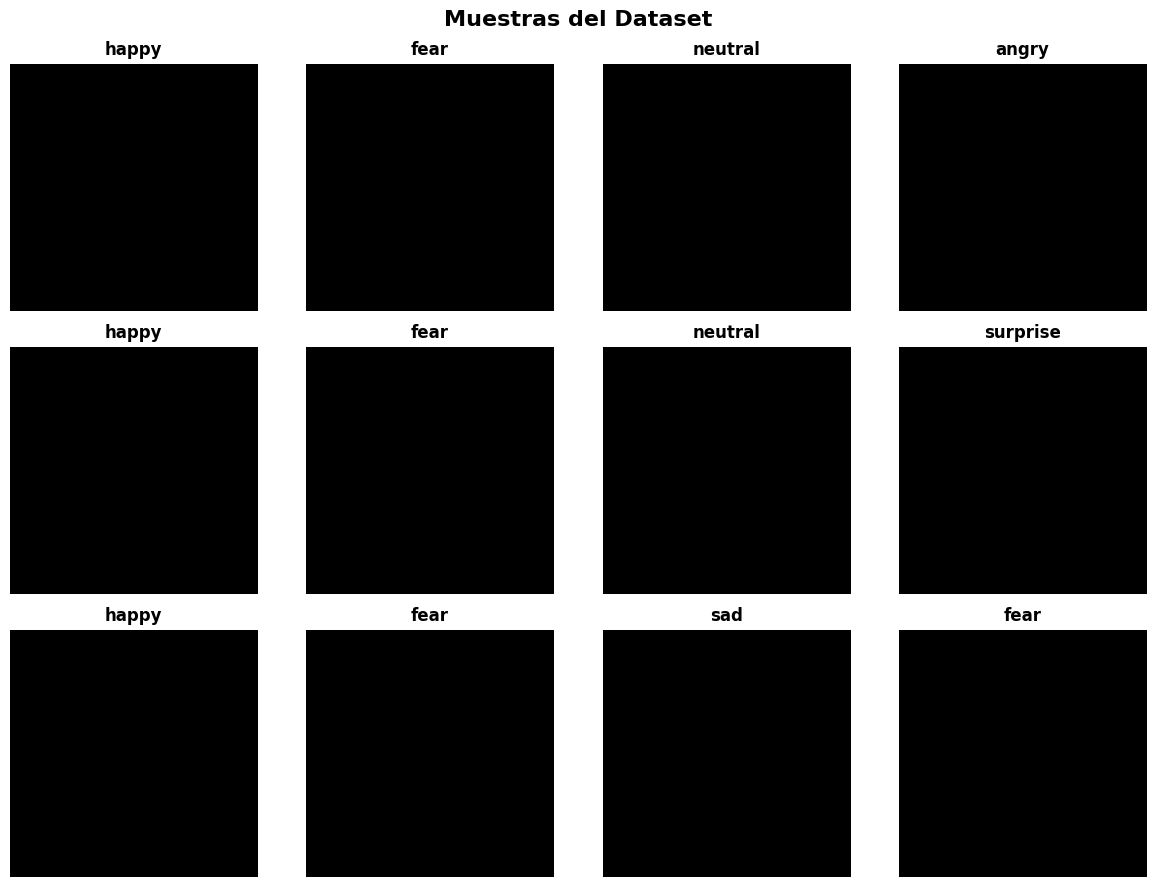

In [16]:
# ============================================
# CELDA 4: Visualizar muestras (protegido contra imágenes corruptas)
# ============================================
# Obtener un batch seguro
dataiter = iter(train_loader)
while True:
    try:
        images, labels = next(dataiter)
        break
    except AssertionError:
        # Saltar batch si hay imagen corrupta
        print("⚠️ Batch con imagen corrupta ignorado, cargando siguiente...")
        continue

# Visualizar 12 imágenes válidas
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()
count = 0

for i in range(len(images)):
    try:
        img = images[i].squeeze().cpu().numpy()
        img = (img * 0.5 + 0.5)  # Desnormalizar
        axes[count].imshow(img, cmap='gray')
        axes[count].set_title(EMOTION_LABELS[labels[i]], fontweight='bold')
        axes[count].axis('off')
        count += 1
        if count >= 12:
            break
    except Exception as e:
        print(f"⚠️ Imagen ignorada en visualización: {e}")
        continue

plt.suptitle('Muestras del Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [17]:
# ============================================
# CELDA 5: Definir arquitectura CNN
# ============================================
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(EmotionCNN, self).__init__()
        
        # Bloque 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Bloque 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Bloque 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Bloque 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Clasificador
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x

# Crear modelo y mover a GPU
model = EmotionCNN(num_classes=NUM_CLASSES).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("MODELO CREADO")
print("="*60)
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Modelo en: {next(model.parameters()).device}")
print("\nArquitectura:")
print(model)


MODELO CREADO
Parámetros totales: 7,182,278
Parámetros entrenables: 7,182,278
Modelo en: cuda:0

Arquitectura:
EmotionCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [18]:
# ============================================
# CELDA 6: Definir loss y optimizer
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Configuración de entrenamiento:")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Scheduler: ReduceLROnPlateau")


SyntaxError: invalid syntax (<string>, line 1)

In [ ]:
# ============================================
# CELDA 7: Modelo final
# ============================================
print("Entrenando modelo final con todo el train set...")
clf_final = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=RANDOM_STATE)
clf_final.fit(X_train_pca, y_train)
print("✓ Modelo final entrenado")


In [ ]:
# ============================================
# CELDA 8: Evaluación en Test
# ============================================
y_pred = clf_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy: {test_acc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=EMOTION_LABELS))


In [ ]:
# ============================================
# CELDA 9: Guardar modelo
# ============================================
modelo_completo = {
    'pca': pca,
    'classifier': clf_final,
    'emotion_labels': EMOTION_LABELS,
    'test_accuracy': test_acc,
    'img_size': IMG_SIZE,
    'n_components': pca.n_components_
}

with open('emotion_model.pkl', 'wb') as f:
    pickle.dump(modelo_completo, f)

print("✓ Modelo guardado como 'emotion_model.pkl'")


In [2]:
# ============================================
# CELDA: CNN optimizada para GPU 
# ============================================

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np

print("============================================")
print("🔍 Comprobando GPU...")
print("GPU detectada:", tf.config.list_physical_devices('GPU'))
print("============================================\n")

# ----- Preparar datos para CNN -----
print("📌 Preparando datos para la CNN ")

X_train_cnn = X_train[..., np.newaxis].astype("float32") / 255.0
X_test_cnn  = X_test[..., np.newaxis].astype("float32") / 255.0

print(f" - Shape X_train_cnn: {X_train_cnn.shape}")
print(f" - Shape X_test_cnn:  {X_test_cnn.shape}")

n_classes = len(EMOTION_LABELS)
print(f" - Número de clases: {n_classes}")

y_train_ohe = tf.keras.utils.to_categorical(y_train, n_classes)
y_test_ohe  = tf.keras.utils.to_categorical(y_test, n_classes)

print("✓ Datos preparados\n")

# ----- Construir modelo CNN -----
print("📌 Construyendo modelo CNN...")

def build_cnn(input_shape=(48,48,1), n_classes=6):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(2)(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(2)(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    return model

model = build_cnn((48,48,1), n_classes)

print("✓ Modelo creado")
print("\n📌 Resumen del modelo:")
model.summary()
print("\n")

# ----- Compilar modelo -----
print("📌 Compilando modelo...")
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print("✓ Modelo compilado\n")

# ----- Callbacks -----
print("📌 Configurando callbacks...")

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)
mc = callbacks.ModelCheckpoint(
    "cnn_best.h5",
    monitor="val_loss",
    save_best_only=True
)
rl = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3
)

print("✓ Callbacks configurados\n")

# ----- ENTRENAMIENTO -----
print("============================================")
print("🚀 COMENZANDO ENTRENAMIENTO CNN (USANDO GPU)")
print("============================================\n")

history = model.fit(
    X_train_cnn, 
    y_train_ohe,
    validation_data=(X_test_cnn, y_test_ohe),
    batch_size=32,
    epochs=40,
    callbacks=[es, mc, rl],
    verbose=1
)

print("\n============================================")
print("🎉 ENTRENAMIENTO COMPLETADO")
print("============================================\n")

print("Guardando mejor modelo como cnn_best.h5 ...")
print("✓ Guardado\n")



🔍 Comprobando GPU...
GPU detectada: []

📌 Preparando datos para la CNN (sin augmentation)...


NameError: name 'X_train' is not defined